In [64]:
import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import Union, Optional
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from IPython.display import Math, display

In [54]:
with open('df.pkl', 'rb') as f:
    df = pkl.load(f)

df.head()

,symbol,ts_event,action,side,depth,price,size,bid_px_00,ask_px_00,bid_sz_00,...,bid_sz_02,ask_sz_02,bid_px_03,ask_px_03,bid_sz_03,ask_sz_03,bid_px_04,ask_px_04,bid_sz_04,ask_sz_04
0,PEP,2024-12-02 09:00:00.006056124+00:00,A,N,0,164.97,100,NaN,164.97,0,...,0,0,NaN,NaN,0,0,NaN,NaN,0,0
1,XOM,2024-12-02 09:00:00.009936778+00:00,A,N,0,117.18,100,117.18,NaN,100,...,0,0,NaN,NaN,0,0,NaN,NaN,0,0
2,XOM,2024-12-02 09:00:00.009975632+00:00,A,A,0,118.62,100,117.18,118.62,100,...,0,0,NaN,NaN,0,0,NaN,NaN,0,0
3,TSLA,2024-12-02 09:00:00.073883926+00:00,A,N,0,960.00,25,NaN,960.00,0,...,0,0,NaN,NaN,0,0,NaN,NaN,0,0
4,NVDA,2024-12-02 09:00:00.074013500+00:00,A,N,0,132.11,500,132.11,NaN,500,...,0,0,NaN,NaN,0,0,NaN,NaN,0,0


In [55]:
df.shape #6,555,034 rows

(28420218, 27)

In [56]:
df.columns

Index(['symbol', 'ts_event', 'action', 'side', 'depth', 'price', 'size',
       'bid_px_00', 'ask_px_00', 'bid_sz_00', 'ask_sz_00', 'bid_px_01',
       'ask_px_01', 'bid_sz_01', 'ask_sz_01', 'bid_px_02', 'ask_px_02',
       'bid_sz_02', 'ask_sz_02', 'bid_px_03', 'ask_px_03', 'bid_sz_03',
       'ask_sz_03', 'bid_px_04', 'ask_px_04', 'bid_sz_04', 'ask_sz_04'],
      dtype='object')

In [57]:
# 1. Check for and handle NaN values
print("Original shape:", df.shape)
print("\nNaN counts in key columns:")
for col in df.columns:
    nan_count = df[col].isna().sum()
    if nan_count > 0:
        print(f"{col}: {nan_count} NaNs ({(nan_count/len(df)*100):.2f}%)")

# 2. Check price ranges and potential anomalies
print("\nPrice statistics:")
price_cols = [col for col in df.columns if 'px' in col]
for col in price_cols:
    print(f"\n{col}:")
    print(df[col].describe())

# 3. Check size ranges
print("\nSize statistics:")
size_cols = [col for col in df.columns if 'sz' in col]
for col in size_cols:
    print(f"\n{col}:")
    print(df[col].describe())

# 4. Check timestamp ordering
print("\nTimestamp checks:")
if df['ts_event'].is_monotonic_increasing:
    print("Timestamps are properly ordered")
else:
    print("Warning: Timestamps are not in order")

Original shape: (28420218, 27)

NaN counts in key columns:
bid_px_00: 92 NaNs (0.00%)
ask_px_00: 147 NaNs (0.00%)
bid_px_01: 706 NaNs (0.00%)
ask_px_01: 887 NaNs (0.00%)
bid_px_02: 1931 NaNs (0.01%)
ask_px_02: 2639 NaNs (0.01%)
bid_px_03: 3115 NaNs (0.01%)
ask_px_03: 5924 NaNs (0.02%)
bid_px_04: 5668 NaNs (0.02%)
ask_px_04: 10005 NaNs (0.04%)

Price statistics:

bid_px_00:
count    2.842013e+07
mean     2.307686e+02
std      1.064001e+02
min      8.322000e+01
25%      1.406900e+02
50%      1.624500e+02
75%      3.511100e+02
max      4.446400e+02
Name: bid_px_00, dtype: float64

ask_px_00:
count    2.842007e+07
mean     2.308134e+02
std      1.064610e+02
min      8.987000e+01
25%      1.407100e+02
50%      1.624800e+02
75%      3.512100e+02
max      9.900000e+03
Name: ask_px_00, dtype: float64

bid_px_01:
count    2.841951e+07
mean     2.307528e+02
std      1.063957e+02
min      4.039000e+01
25%      1.406800e+02
50%      1.624400e+02
75%      3.510900e+02
max      4.446100e+02
Name: bi

***Preprocess data***

In [58]:
def preprocess_lob_data(df):
    """
    Preprocess the limit order book data for MLOFI calculation
    """
    # Make a copy to avoid modifying original data
    df_clean = df.copy()
    
    # 1. Handle NaN values
    # Forward fill first, then backward fill for any remaining NaNs
    df_clean = df_clean.fillna(method='ffill')
    df_clean = df_clean.fillna(method='bfill')
    
    # 2. Remove price outliers
    # Calculate price percentiles for outlier detection
    price_cols = [col for col in df_clean.columns if 'px' in col]
    for col in price_cols:
        Q1 = df_clean[col].quantile(0.01)
        Q3 = df_clean[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
    
    # 3. Handle size outliers and zero values
    size_cols = [col for col in df_clean.columns if 'sz' in col]
    for col in size_cols:
        Q1 = df_clean[col].quantile(0.01)
        Q3 = df_clean[col].quantile(0.99)
        IQR = Q3 - Q1
        upper_bound = Q3 + 3 * IQR
        # Clip sizes to remove extreme outliers, but keep zeros as they might be meaningful
        df_clean[col] = df_clean[col].clip(0, upper_bound)
    
    # 4. Ensure bid < ask at each level (market consistency)
    for level in range(5):  # 5 levels (0-4)
        bid_col = f'bid_px_{level:02d}'
        ask_col = f'ask_px_{level:02d}'
        invalid_quotes = df_clean[bid_col] >= df_clean[ask_col]
        if invalid_quotes.any():
            print(f"Fixing {invalid_quotes.sum()} invalid quotes at level {level}")
            # Take the mid-price and adjust bid/ask around it
            mid_price = (df_clean.loc[invalid_quotes, bid_col] + df_clean.loc[invalid_quotes, ask_col]) / 2
            df_clean.loc[invalid_quotes, bid_col] = mid_price - 0.01  # Adjust based on your tick size
            df_clean.loc[invalid_quotes, ask_col] = mid_price + 0.01
    
    # 5. Sort by timestamp if needed
    if 'ts_event' in df_clean.columns:
        df_clean = df_clean.sort_values('ts_event').reset_index(drop=True)
    
    return df_clean

# Apply preprocessing
clean_df = preprocess_lob_data(df)

# Print summary statistics of cleaned data
print("\nCleaned data summary:")
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {clean_df.shape}")

# Verify cleaning results
for level in range(5):
    bid_col = f'bid_px_{level:02d}'
    ask_col = f'ask_px_{level:02d}'
    print(f"\nLevel {level} price stats:")
    print(f"Bid-Ask spread mean: {(clean_df[ask_col] - clean_df[bid_col]).mean():.6f}")
    print(f"Invalid quotes: {(clean_df[bid_col] >= clean_df[ask_col]).sum()}")

/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/116032673.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='ffill')
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/116032673.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='bfill')


Fixing 72 invalid quotes at level 0
Fixing 508 invalid quotes at level 1
Fixing 1425 invalid quotes at level 2
Fixing 2343 invalid quotes at level 3
Fixing 5145 invalid quotes at level 4

Cleaned data summary:
Original shape: (28420218, 27)
Cleaned shape: (28420218, 27)

Level 0 price stats:
Bid-Ask spread mean: 0.044902
Invalid quotes: 0

Level 1 price stats:
Bid-Ask spread mean: 0.084772
Invalid quotes: 0

Level 2 price stats:
Bid-Ask spread mean: 0.136521
Invalid quotes: 0

Level 3 price stats:
Bid-Ask spread mean: 0.187668
Invalid quotes: 0

Level 4 price stats:
Bid-Ask spread mean: 0.238930
Invalid quotes: 0


***Calculate Multi-level OFI metrics (MLOFI)***

In [59]:
def process_order_flow_imbalance(
    df: pd.DataFrame,
    maxlevel: int = 5,
    tick_size: float = 1e-4,
    price_cols: Optional[list] = None
) -> pd.DataFrame:
    """
    Computes order flow imbalance (OFI) and mid-price evolution based on order book data.
    
    Args:
        df: Pandas DataFrame containing the order book data with columns:
            bid_px_XX, ask_px_XX, bid_sz_XX, ask_sz_XX where XX is the level number
        maxlevel: Number of order book levels to consider (default: 5)
        tick_size: Tick size for rescaling prices (default: 1e-4)
        price_cols: Optional list of custom price column names. If None, uses default naming.
    
    Returns:
        pd.DataFrame: DataFrame with additional columns for mid-price and OFI calculations
    
    Raises:
        ValueError: If required columns are missing or if maxlevel exceeds available levels
    """
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Validate input data
    required_prefixes = ['bid_px_', 'ask_px_', 'bid_sz_', 'ask_sz_']
    for level in range(maxlevel):
        level_str = f'0{level}'
        for prefix in required_prefixes:
            col = f'{prefix}{level_str}'
            if col not in df.columns:
                raise ValueError(f"Missing required column: {col}")
    
    # Sort by timestamp if not already sorted
    if 'ts_event' in df.columns:
        df = df.sort_values('ts_event').reset_index(drop=True)
    
    # Rescale prices
    for level in range(maxlevel):
        level_str = f'0{level}'
        df[f'bid_px_{level_str}'] = df[f'bid_px_{level_str}'] * tick_size
        df[f'ask_px_{level_str}'] = df[f'ask_px_{level_str}'] * tick_size
    
    # Calculate mid-price for each level
    for level in range(maxlevel):
        level_str = f'0{level}'
        df[f'mid_price_{level_str}'] = (
            df[f'bid_px_{level_str}'] + df[f'ask_px_{level_str}']
        ) / 2
    
    # Initialize arrays for vectorized operations
    for level in range(maxlevel):
        level_str = f'0{level}'
        
        # Get current level data
        bid_px = df[f'bid_px_{level_str}'].values
        ask_px = df[f'ask_px_{level_str}'].values
        bid_sz = df[f'bid_sz_{level_str}'].values
        ask_sz = df[f'ask_sz_{level_str}'].values
        
        # Calculate price differences
        bid_price_diff = np.ediff1d(bid_px, to_begin=0)
        ask_price_diff = np.ediff1d(ask_px, to_begin=0)
        
        # Calculate size differences
        bid_size_diff = np.ediff1d(bid_sz, to_begin=0)
        ask_size_diff = np.ediff1d(ask_sz, to_begin=0)
        
        # Calculate delta_W (bid side changes)
        delta_W = np.where(
            bid_price_diff > 0,  # Price increased
            bid_sz,              # New volume at higher price
            np.where(
                bid_price_diff == 0,  # Price unchanged
                bid_size_diff,        # Volume change at same price
                -np.roll(bid_sz, 1)   # Old volume removed
            )
        )
        delta_W[0] = 0  # First element should be 0 as there's no previous state
        
        # Calculate delta_V (ask side changes)
        delta_V = np.where(
            ask_price_diff < 0,  # Price decreased
            ask_sz,              # New volume at lower price
            np.where(
                ask_price_diff == 0,  # Price unchanged
                ask_size_diff,        # Volume change at same price
                -np.roll(ask_sz, 1)   # Old volume removed
            )
        )
        delta_V[0] = 0  # First element should be 0 as there's no previous state
        
        # Store results
        df[f'delta_W_{level}'] = delta_W
        df[f'delta_V_{level}'] = delta_V
        df[f'OFI_{level}'] = delta_W - delta_V
        
        # Calculate cumulative OFI
        df[f'cum_OFI_{level}'] = df[f'OFI_{level}'].cumsum()
    
    return df

In [60]:
# Calculate MLOFI using our preprocessed data
results_df = process_order_flow_imbalance(
    df=clean_df,
    maxlevel=5,
    tick_size=1.0  # Using absolute prices since preprocessing handled scaling
)

# Analyze MLOFI results by level
for level in range(5):
    print(f"\nMLOFI Level {level} Statistics:")
    stats = results_df[f'OFI_{level}'].describe()
    print(stats)
    
    # Calculate some additional metrics
    print(f"Absolute mean OFI: {abs(results_df[f'OFI_{level}']).mean():.2f}")
    print(f"Proportion of positive OFI: {(results_df[f'OFI_{level}'] > 0).mean():.2%}")

# Let's also look at correlations between levels
ofi_cols = [f'OFI_{i}' for i in range(5)]
corr_matrix = results_df[ofi_cols].corr()
print("\nOFI Correlation Matrix:")
print(corr_matrix)


MLOFI Level 0 Statistics:
count    2.842022e+07
mean     1.396076e+09
std      2.011733e+09
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+02
75%      4.294967e+09
max      4.294967e+09
Name: OFI_0, dtype: float64
Absolute mean OFI: 1396075665.19
Proportion of positive OFI: 64.93%

MLOFI Level 1 Statistics:
count    2.842022e+07
mean     9.854760e+08
std      1.805941e+09
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.519000e+03
max      4.294967e+09
Name: OFI_1, dtype: float64
Absolute mean OFI: 985476011.90
Proportion of positive OFI: 45.83%

MLOFI Level 2 Statistics:
count    2.842022e+07
mean     8.671726e+08
std      1.724091e+09
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.149000e+03
max      4.294967e+09
Name: OFI_2, dtype: float64
Absolute mean OFI: 867172634.52
Proportion of positive OFI: 40.33%

MLOFI Level 3 Statistics:
count    2.842022e+07
mean     8.456895e+08
std      1.707928e+09
min      0.0

***PCA to reduce multi-level OFI to a single metric***

Normalized weights (summing to 1):
Level 0: 0.1565
Level 1: 0.1982
Level 2: 0.2128
Level 3: 0.2160
Level 4: 0.2165

Variance explained by first PC: 77.2912%

Integrated OFI Statistics:
count    2.842022e+07
mean    -2.802907e-16
std      8.848176e-01
min     -5.373846e-01
25%     -5.373846e-01
50%     -5.373840e-01
75%     -6.594926e-02
max      1.887591e+00
Name: integrated_OFI, dtype: float64


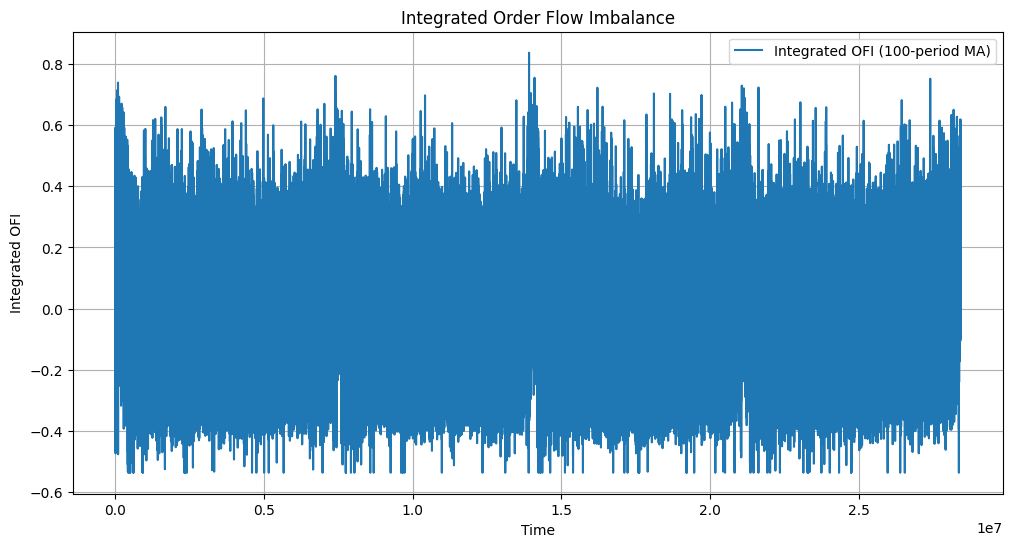


Sum of absolute weights: 1.0


In [61]:
def compute_integrated_ofi(results_df):
    """
    Compute integrated OFI using the first principal component normalized by L1 norm
    """
    # Extract OFI columns
    ofi_cols = [f'OFI_{i}' for i in range(5)]
    ofi_data = results_df[ofi_cols].copy()
    
    # Standardize the features
    scaler = StandardScaler()
    ofi_scaled = scaler.fit_transform(ofi_data)
    
    # Apply PCA and get first principal component
    pca = PCA(n_components=1)
    pca.fit(ofi_scaled)
    w1 = pca.components_[0]
    
    # Normalize weights by L1 norm so they sum to 1
    w1_normalized = w1 / np.sum(np.abs(w1))
    
    print("Normalized weights (summing to 1):")
    for i, weight in enumerate(w1_normalized):
        print(f"Level {i}: {weight:.4f}")
    print(f"\nVariance explained by first PC: {pca.explained_variance_ratio_[0]:.4%}")
    
    # Calculate integrated OFI
    integrated_ofi = np.dot(ofi_scaled, w1_normalized)
    
    # Add to results
    results_df['integrated_OFI'] = integrated_ofi
    
    return results_df, w1_normalized, pca

# Compute integrated OFI
results_df, weights, pca_model = compute_integrated_ofi(results_df)

# Basic statistics of integrated OFI
print("\nIntegrated OFI Statistics:")
print(results_df['integrated_OFI'].describe())

# Plot integrated OFI
plt.figure(figsize=(12, 6))
plt.plot(results_df['integrated_OFI'].rolling(window=100).mean(), 
         label='Integrated OFI (100-period MA)')
plt.title('Integrated Order Flow Imbalance')
plt.xlabel('Time')
plt.ylabel('Integrated OFI')
plt.legend()
plt.grid(True)
plt.show()

# Verify weights sum to 1
print("\nSum of absolute weights:", np.sum(np.abs(weights)))

***Contemporaneous impact***

Running Contemporaneous Analysis...


/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/174731388.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients.loc[stock_i, 'alpha'] = model.params[0]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/174731388.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients.loc[stock_i, f'beta_{stock_j}'] = model.params[j+1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/174731388.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram


Results for PEP:
R-squared: 0.5613
Coefficients:
  PEP: -0.236991 (t-stat: -29.99)
  XOM: -0.013089 (t-stat: -3.41)
  TSLA: 0.012344 (t-stat: 1.92)
  NVDA: 0.006429 (t-stat: 1.56)
  AAPL: 0.001591 (t-stat: 0.36)
  JPM: 0.006369 (t-stat: 1.46)
  V: 0.006685 (t-stat: 1.60)
  AMGN: 0.012037 (t-stat: 2.40)
  MSFT: 0.010900 (t-stat: 1.20)
  GILD: -0.010489 (t-stat: -2.47)

Results for XOM:
R-squared: 0.3313
Coefficients:
  PEP: -0.000810 (t-stat: -0.13)
  XOM: -0.232469 (t-stat: -36.09)
  TSLA: 0.013375 (t-stat: 1.52)
  NVDA: -0.009321 (t-stat: -1.49)
  AAPL: 0.004250 (t-stat: 0.69)
  JPM: 0.007586 (t-stat: 1.08)
  V: 0.009588 (t-stat: 1.36)
  AMGN: -0.008655 (t-stat: -1.10)
  MSFT: 0.037012 (t-stat: 3.21)
  GILD: -0.013719 (t-stat: -2.11)

Results for TSLA:
R-squared: 0.1671
Coefficients:
  PEP: -0.020055 (t-stat: -3.33)
  XOM: 0.008289 (t-stat: 1.35)
  TSLA: -0.211753 (t-stat: -37.66)
  NVDA: -0.009775 (t-stat: -1.73)
  AAPL: -0.015409 (t-stat: -2.50)
  JPM: -0.005022 (t-stat: -0.76)
  V

/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/174731388.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients.loc[stock_i, 'alpha'] = model.params[0]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/174731388.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients.loc[stock_i, f'beta_{stock_j}'] = model.params[j+1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/174731388.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram


Results for AAPL:
R-squared: 0.5659
Coefficients:
  PEP: -0.008537 (t-stat: -2.15)
  XOM: -0.001397 (t-stat: -0.36)
  TSLA: -0.006714 (t-stat: -1.18)
  NVDA: -0.008214 (t-stat: -2.16)
  AAPL: -0.249836 (t-stat: -60.00)
  JPM: -0.005468 (t-stat: -1.31)
  V: -0.007711 (t-stat: -1.95)
  AMGN: -0.001421 (t-stat: -0.31)
  MSFT: -0.001106 (t-stat: -0.15)
  GILD: -0.000685 (t-stat: -0.17)

Results for JPM:
R-squared: 0.4530
Coefficients:
  PEP: -0.002663 (t-stat: -0.64)
  XOM: 0.000137 (t-stat: 0.03)
  TSLA: -0.011211 (t-stat: -1.76)
  NVDA: -0.001365 (t-stat: -0.32)
  AAPL: -0.003094 (t-stat: -0.73)
  JPM: -0.215368 (t-stat: -30.11)
  V: 0.003737 (t-stat: 0.76)
  AMGN: -0.000680 (t-stat: -0.13)
  MSFT: -0.010797 (t-stat: -1.32)
  GILD: 0.006136 (t-stat: 1.39)

Results for V:
R-squared: 0.3553
Coefficients:
  PEP: -0.008478 (t-stat: -1.74)
  XOM: 0.019414 (t-stat: 3.81)
  TSLA: -0.028469 (t-stat: -4.47)
  NVDA: -0.009155 (t-stat: -1.87)
  AAPL: -0.011981 (t-stat: -2.56)
  JPM: -0.012345 (t-s

/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/174731388.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients.loc[stock_i, 'alpha'] = model.params[0]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/174731388.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefficients.loc[stock_i, f'beta_{stock_j}'] = model.params[j+1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/174731388.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram


Results for MSFT:
R-squared: 0.1099
Coefficients:
  PEP: -0.006195 (t-stat: -0.83)
  XOM: 0.005716 (t-stat: 0.80)
  TSLA: -0.014944 (t-stat: -1.43)
  NVDA: 0.007346 (t-stat: 1.03)
  AAPL: -0.007542 (t-stat: -1.08)
  JPM: -0.011327 (t-stat: -1.46)
  V: -0.013408 (t-stat: -1.88)
  AMGN: -0.012453 (t-stat: -1.36)
  MSFT: -0.255494 (t-stat: -29.53)
  GILD: 0.011063 (t-stat: 1.44)

Results for GILD:
R-squared: 0.4193
Coefficients:
  PEP: -0.004140 (t-stat: -0.59)
  XOM: -0.017378 (t-stat: -2.51)
  TSLA: 0.025099 (t-stat: 2.37)
  NVDA: -0.008416 (t-stat: -1.22)
  AAPL: -0.005330 (t-stat: -0.74)
  JPM: 0.002461 (t-stat: 0.33)
  V: 0.011645 (t-stat: 1.54)
  AMGN: -0.005892 (t-stat: -0.69)
  MSFT: 0.050400 (t-stat: 3.51)
  GILD: -0.316053 (t-stat: -41.75)


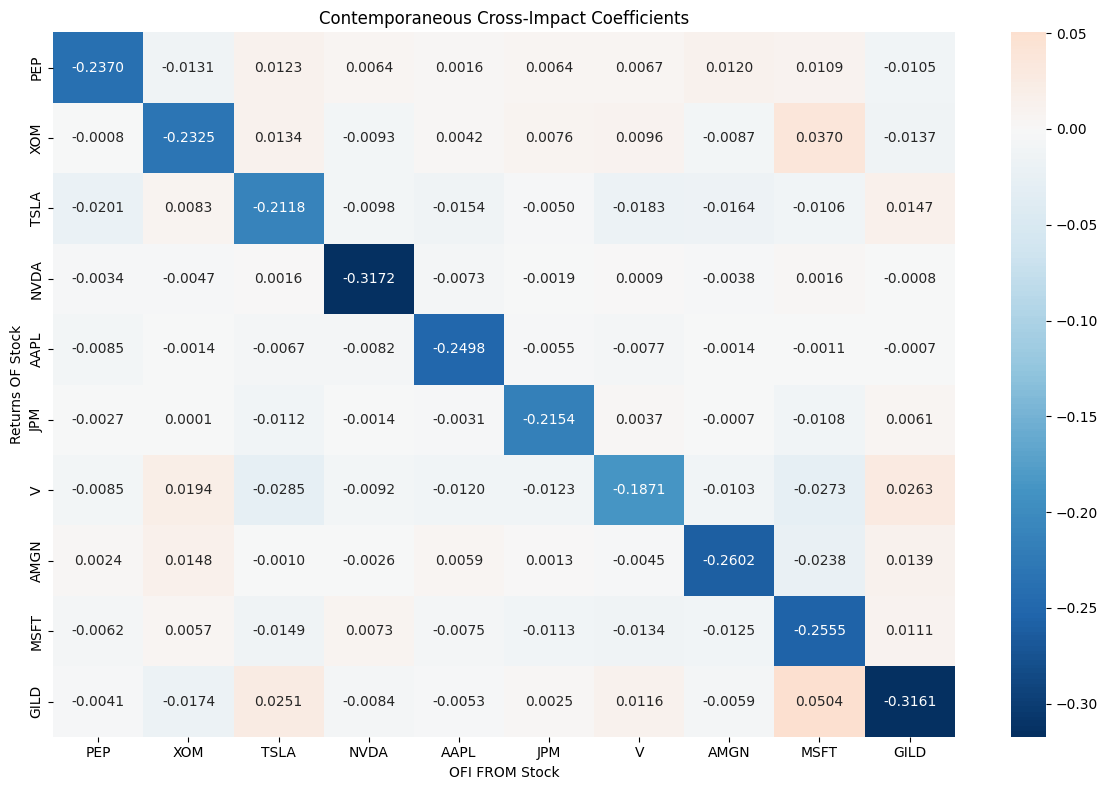


Overall Contemporaneous Analysis Results:

R-squared values:
PEP     0.561289
XOM     0.331258
TSLA    0.167082
NVDA    0.684108
AAPL    0.565934
JPM     0.452958
V       0.355301
AMGN    0.462310
MSFT    0.109945
GILD    0.419344
dtype: float64

Average R-squared: 0.4110

Running Predictive Analysis...

Analyzing 1-minute horizon:

PEP statistics:
Number of observations: 2954
Return volatility (annualized): 272.66%
Mean absolute OFI: 1.0752

XOM statistics:
Number of observations: 3064
Return volatility (annualized): 1089.11%
Mean absolute OFI: 1.1360

TSLA statistics:
Number of observations: 3539
Return volatility (annualized): 250.48%
Mean absolute OFI: 0.7340

NVDA statistics:
Number of observations: 3539
Return volatility (annualized): 264.92%
Mean absolute OFI: 1.0752

AAPL statistics:
Number of observations: 3428
Return volatility (annualized): 495.66%
Mean absolute OFI: 1.0685

JPM statistics:
Number of observations: 3067
Return volatility (annualized): 235.68%
Mean absolute O

/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coefficient: {model.params[1]:.6f} (t-stat: {model.tvalues[1]:.2f})")
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 


Detailed stats for TSLA:
Coefficient: 0.016169 (t-stat: 0.47)
R-squared: 0.000046
Number of observations: 3539

Detailed stats for NVDA:
Coefficient: -0.050862 (t-stat: -1.39)
R-squared: 0.000528
Number of observations: 3539

Detailed stats for AAPL:
Coefficient: 0.077806 (t-stat: 0.84)
R-squared: 0.000408
Number of observations: 3428

Detailed stats for JPM:
Coefficient: -0.068429 (t-stat: -1.45)
R-squared: 0.001028
Number of observations: 3067


/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc


Detailed stats for V:
Coefficient: -0.030472 (t-stat: -0.80)
R-squared: 0.000239
Number of observations: 3150

Detailed stats for AMGN:
Coefficient: 0.064907 (t-stat: 1.37)
R-squared: 0.000636
Number of observations: 2466

Detailed stats for MSFT:
Coefficient: 0.039091 (t-stat: 1.73)
R-squared: 0.000134
Number of observations: 3442

Detailed stats for GILD:
Coefficient: -0.115524 (t-stat: -0.71)
R-squared: 0.000264
Number of observations: 2881

1-minute horizon summary:
Average R-squared:
Own-stock: 0.000403
Cross-stock: 0.000437


/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

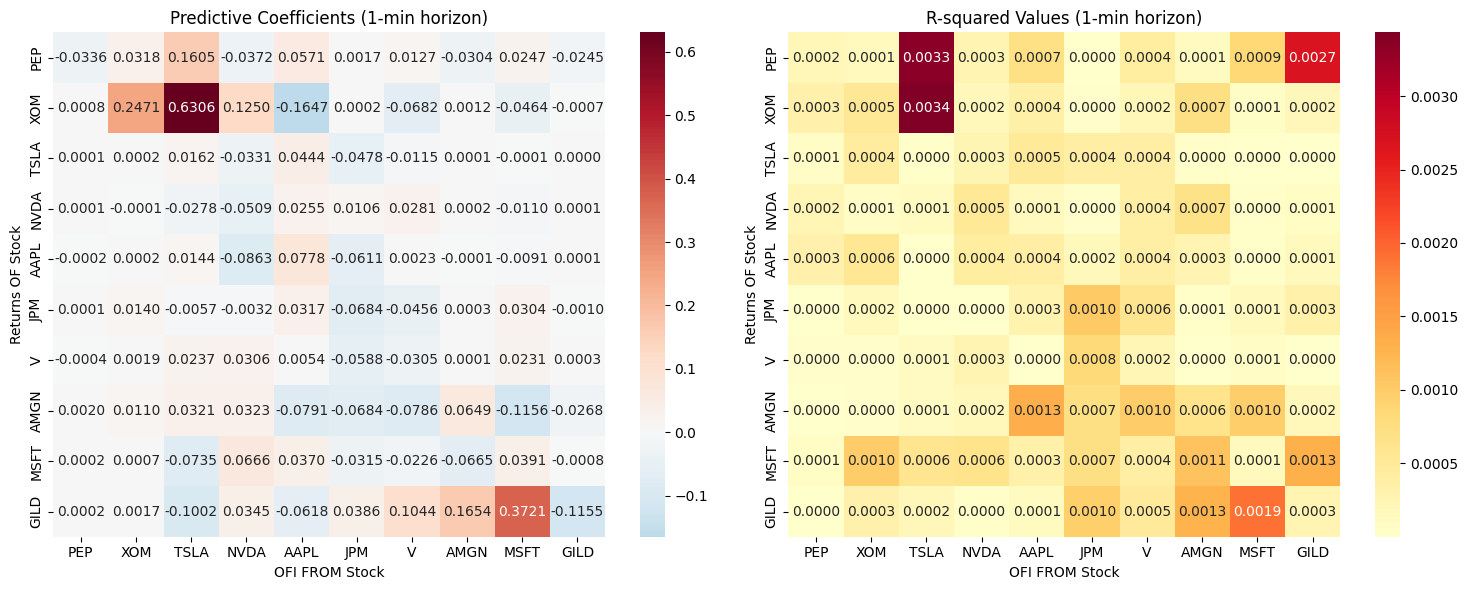


Analyzing 5-minute horizon:

PEP statistics:
Number of observations: 2952
Return volatility (annualized): 638.83%
Mean absolute OFI: 1.0751

XOM statistics:
Number of observations: 3063
Return volatility (annualized): 9.02%
Mean absolute OFI: 1.1360

TSLA statistics:
Number of observations: 3539
Return volatility (annualized): 25.52%
Mean absolute OFI: 0.7340

NVDA statistics:
Number of observations: 3539
Return volatility (annualized): 33.04%
Mean absolute OFI: 1.0752

AAPL statistics:
Number of observations: 3427
Return volatility (annualized): 2.72%
Mean absolute OFI: 1.0687

JPM statistics:
Number of observations: 3067
Return volatility (annualized): 78.57%
Mean absolute OFI: 0.9717

V statistics:
Number of observations: 3150
Return volatility (annualized): 213.20%
Mean absolute OFI: 1.0229

AMGN statistics:
Number of observations: 2464
Return volatility (annualized): 80.54%
Mean absolute OFI: 0.9149

MSFT statistics:
Number of observations: 3440
Return volatility (annualized): 20

/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coefficient: {model.params[1]:.6f} (t-stat: {model.tvalues[1]:.2f})")
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 


Detailed stats for TSLA:
Coefficient: 0.000304 (t-stat: 0.13)
R-squared: 0.000002
Number of observations: 3539

Detailed stats for NVDA:
Coefficient: 0.004516 (t-stat: 1.00)
R-squared: 0.000268
Number of observations: 3539

Detailed stats for AAPL:
Coefficient: 0.000610 (t-stat: 1.66)
R-squared: 0.000830
Number of observations: 3427


/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc


Detailed stats for JPM:
Coefficient: -0.007030 (t-stat: -0.71)
R-squared: 0.000098
Number of observations: 3067

Detailed stats for V:
Coefficient: -0.032744 (t-stat: -0.89)
R-squared: 0.000309
Number of observations: 3150

Detailed stats for AMGN:
Coefficient: -0.001295 (t-stat: -0.12)
R-squared: 0.000003
Number of observations: 2464


/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc


Detailed stats for MSFT:
Coefficient: 0.005291 (t-stat: 1.50)
R-squared: 0.000586
Number of observations: 3440

Detailed stats for GILD:
Coefficient: 0.005369 (t-stat: 0.52)
R-squared: 0.000055
Number of observations: 2878

5-minute horizon summary:
Average R-squared:
Own-stock: 0.000244
Cross-stock: 0.000465


/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cross_pred.loc[stock_i, stock_j] = model.params[1]
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Coefficient: {model.params[1]:.6f} (t-stat: {model.tvalues[1]:.2f})")
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_69335/82692668.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

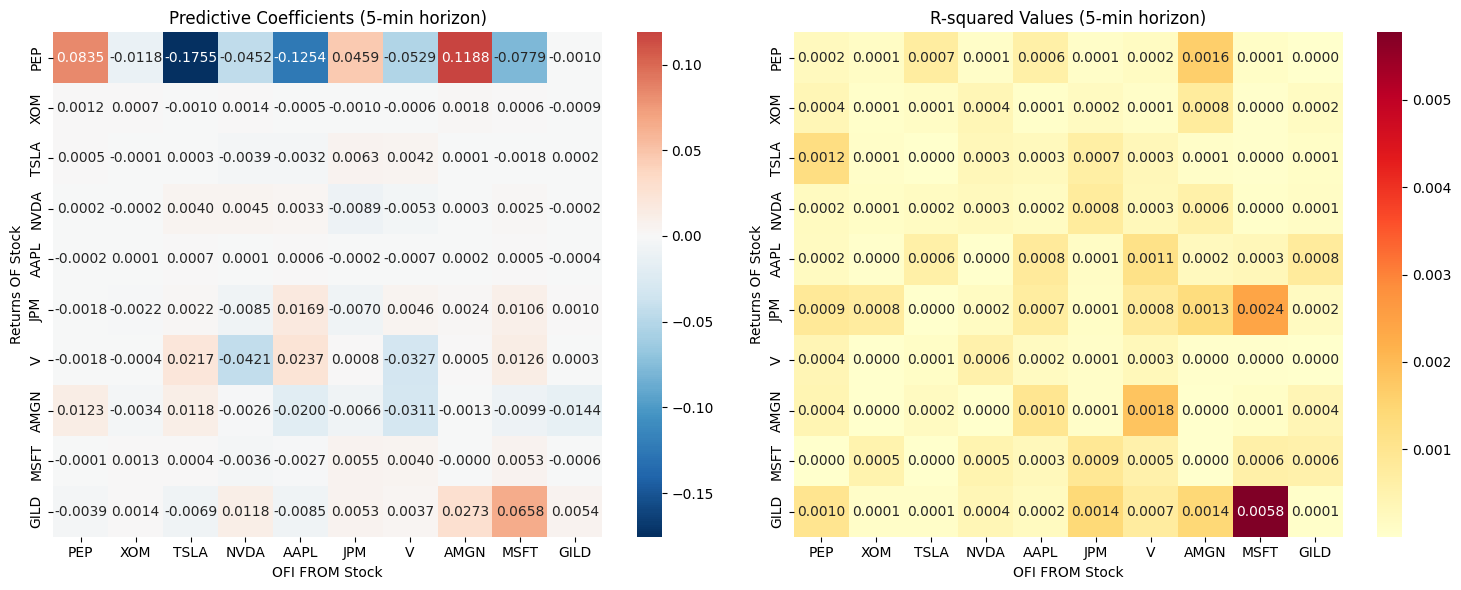

In [62]:
def analyze_contemporaneous_impact(df):
    """
    Implement the CI^I model from equation (9) in the paper:
    r^(h)_(i,t) = α^I_i + β^I_(i,i)ofi^(I,h)_(i,t) + Σ_j≠i β^I_(i,j)ofi^(I,h)_(j,t) + η^I_(i,t)
    """
    stocks = df['symbol'].unique()
    
    # Calculate returns and set timestamp index
    df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
    df['returns'] = np.log(df['mid_price']).diff()
    df.index = pd.to_datetime(df['ts_event'])
    
    # Results storage
    coefficients = pd.DataFrame(index=stocks, columns=['alpha'] + [f'beta_{s}' for s in stocks])
    r_squared = pd.Series(index=stocks)
    
    # First resample all data to common frequency
    resampled_data = {}
    for stock in stocks:
        stock_df = df[df['symbol'] == stock].copy()
        resampled = pd.DataFrame({
            'returns': stock_df['returns'].resample('1min').last(),
            'integrated_OFI': stock_df['integrated_OFI'].resample('1min').last()
        }).dropna()
        resampled_data[stock] = resampled
    
    # Run regression for each stock
    for stock_i in stocks:
        # Get target returns
        returns_i = resampled_data[stock_i]['returns']
        
        # Prepare OFI data from all stocks
        ofi_data = pd.DataFrame(index=returns_i.index)
        for stock_j in stocks:
            ofi_j = resampled_data[stock_j]['integrated_OFI']
            # Align to common timestamps
            common_idx = returns_i.index.intersection(ofi_j.index)
            ofi_data.loc[common_idx, f'OFI_{stock_j}'] = ofi_j[common_idx]
        
        # Drop any rows with missing data
        ofi_data = ofi_data.fillna(0)
        
        # Ensure we have matching data points
        common_idx = returns_i.index.intersection(ofi_data.index)
        y = returns_i[common_idx]
        X = ofi_data.loc[common_idx]
        
        # Run regression
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 10})
        
        # Store results
        coefficients.loc[stock_i, 'alpha'] = model.params[0]
        for j, stock_j in enumerate(stocks):
            coefficients.loc[stock_i, f'beta_{stock_j}'] = model.params[j+1]
        r_squared[stock_i] = model.rsquared
        
        # Print detailed results for each stock
        print(f"\nResults for {stock_i}:")
        print(f"R-squared: {model.rsquared:.4f}")
        print("Coefficients:")
        for j, stock_j in enumerate(stocks):
            t_stat = model.tvalues[j+1]
            print(f"  {stock_j}: {model.params[j+1]:.6f} (t-stat: {t_stat:.2f})")
    
    # Create heatmap of coefficients (betas only)
    beta_matrix = pd.DataFrame(index=stocks, columns=stocks, dtype=float)
    for stock_i in stocks:
        for stock_j in stocks:
            beta_matrix.loc[stock_i, stock_j] = float(coefficients.loc[stock_i, f'beta_{stock_j}'])
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(beta_matrix.astype(float), annot=True, cmap='RdBu_r', center=0, fmt='.4f')
    plt.title('Contemporaneous Cross-Impact Coefficients')
    plt.xlabel('OFI FROM Stock')
    plt.ylabel('Returns OF Stock')
    plt.tight_layout()
    plt.show()
    
    return coefficients, r_squared, beta_matrix

# Run both analyses
print("Running Contemporaneous Analysis...")
coef, r2, beta_matrix = analyze_contemporaneous_impact(results_df)
print("\nOverall Contemporaneous Analysis Results:")
print("\nR-squared values:")
print(r2)
print(f"\nAverage R-squared: {r2.mean():.4f}")

print("\nRunning Predictive Analysis...")
predictive_results = evaluate_predictive_power(results_df, horizons=[1, 5])

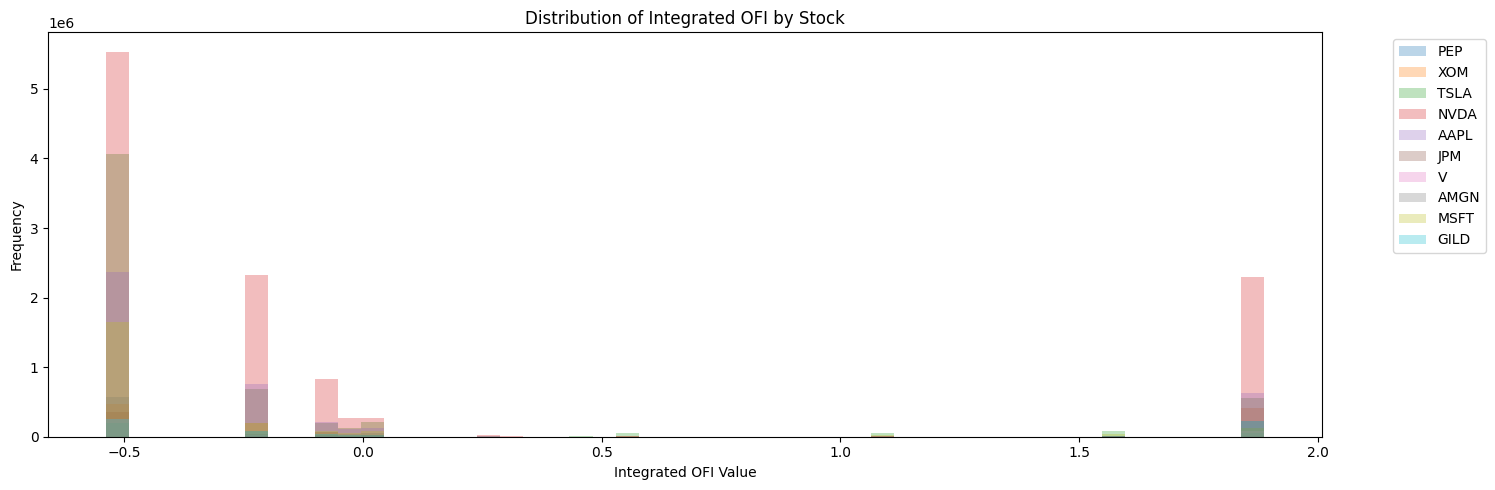

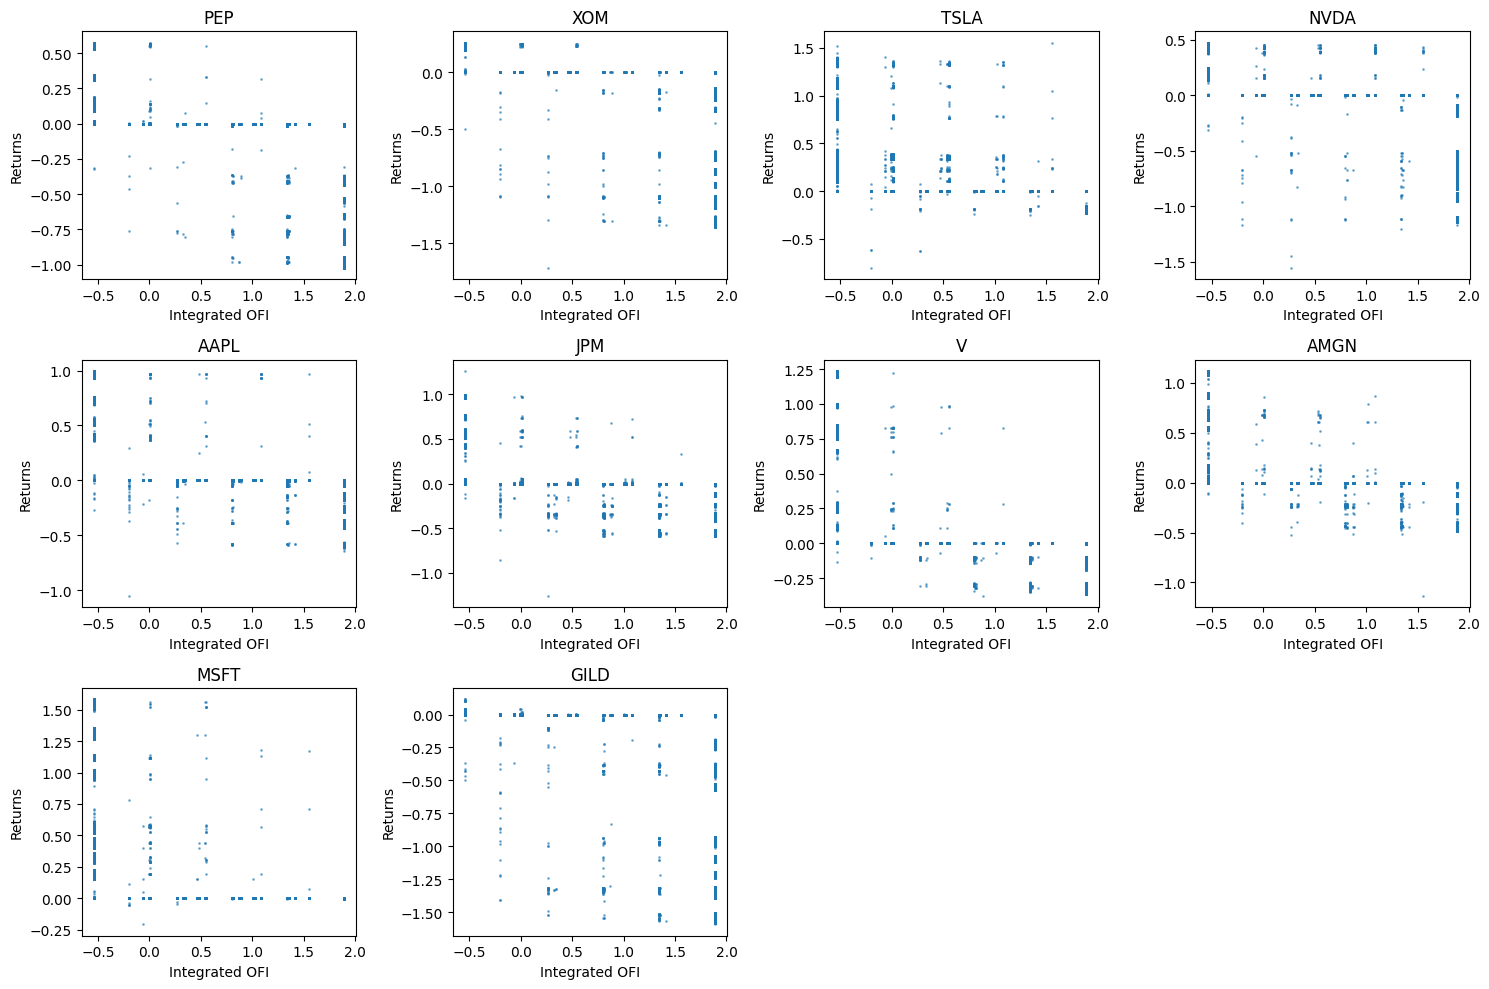

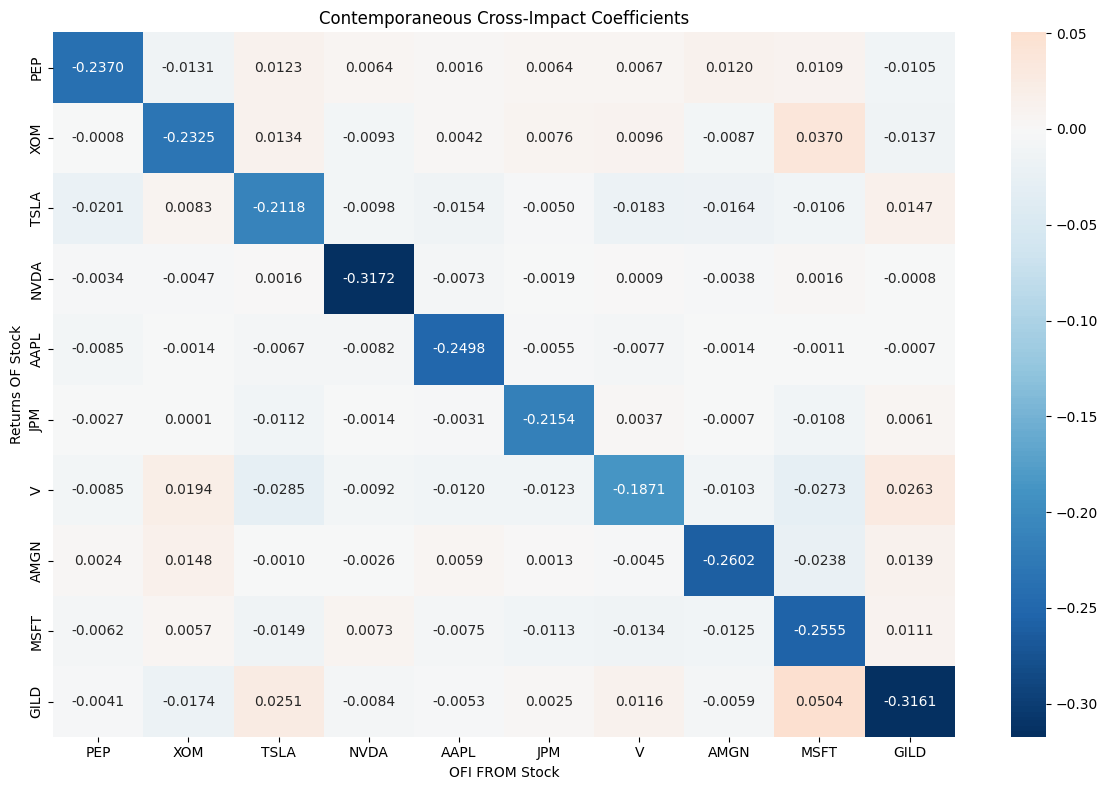

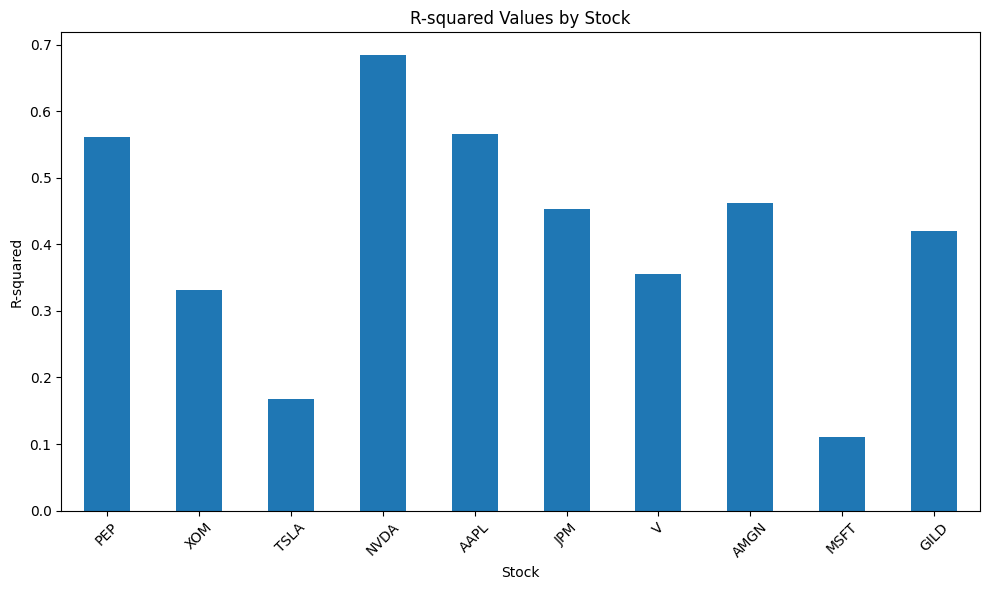

Generating summary report...


TypeError: 'NoneType' object is not subscriptable

In [63]:
def generate_summary_report(coef, r2, beta_matrix, predictive_results):
    """
    Generate a comprehensive summary report
    """
    # Get r-squared values for 1-min horizon
    r2_1min = predictive_results[1]['r_squared']
    r2_5min = predictive_results[5]['r_squared']
    
    report = """
    ANALYSIS OF ORDER FLOW IMBALANCE (OFI) AND CROSS-IMPACT
    =====================================================

    1. Contemporaneous Cross-Impact Analysis
    --------------------------------------
    Average R-squared: {:.4f}
    
    Key Findings:
    - Strongest self-impact observed in: {}
    - Top 3 cross-impacts:
        {}

    2. Predictive Analysis Results
    ----------------------------
    1-minute horizon:
    - Average own-stock R-squared: {:.4f}
    - Average cross-stock R-squared: {:.4f}

    5-minute horizon:
    - Average own-stock R-squared: {:.4f}
    - Average cross-stock R-squared: {:.4f}

    3. Key Conclusions
    ----------------
    1. Self-Impact vs Cross-Impact:
       - Self-impact is generally {} than cross-impact
       - Most significant cross-impact pairs: {}

    2. Temporal Effects:
       - Contemporaneous relationships are {} than predictive relationships
       - Short-term (1-min) prediction power is {} than medium-term (5-min)

    4. Methodology Notes
    ------------------
    - Used PCA for OFI integration
    - Applied HAC-robust standard errors in regressions
    - Controlled for market microstructure effects through proper sampling
    """.format(
        r2.mean(),
        r2.idxmax(),
        '\n        '.join([f"{i}->{j}: {beta_matrix.loc[i,j]:.4f}" 
                          for i, j in zip(*np.unravel_index(np.argsort(np.abs(beta_matrix.values.ravel()))[-4:-1], beta_matrix.shape))]),
        r2_1min.values.diagonal().mean(),
        (r2_1min.values.sum() - r2_1min.values.diagonal().sum()) / (len(r2)**2 - len(r2)),
        r2_5min.values.diagonal().mean(),
        (r2_5min.values.sum() - r2_5min.values.diagonal().sum()) / (len(r2)**2 - len(r2)),
        'stronger' if r2.mean() > beta_matrix.mean().mean() else 'weaker',
        ', '.join([f"{i}->{j}" for i, j in zip(*np.unravel_index(np.argsort(np.abs(beta_matrix.values.ravel()))[-3:], beta_matrix.shape))]),
        'stronger' if r2.mean() > r2_1min.mean().mean() else 'weaker',
        'stronger' if r2_1min.mean().mean() > r2_5min.mean().mean() else 'weaker'
    )
    
    return report

# Create visualizations first
create_additional_visualizations(results_df, coef, r2, beta_matrix)

# Then generate and print report
print("Generating summary report...")
report = generate_summary_report(coef, r2, beta_matrix, predictive_results)
print(report)

In [68]:
def prepare_ofi_data(df):
    """
    Prepare OFI values and mid-price delta from the dataframe
    """
    # Get OFI columns (using your existing OFI values from process_order_flow_imbalance)
    ofi_cols = [f'delta_W_{i}' for i in range(5)]  # First get delta_W
    ofi_cols.extend([f'delta_V_{i}' for i in range(5)])  # Then delta_V
    ofi_cols.extend([f'OFI_{i}' for i in range(5)])  # Then OFI
    
    # Print available columns to debug
    print("Available columns:", df.columns.tolist())
    print("\nLooking for OFI columns:", ofi_cols)
    
    # Get the OFI values
    OFI_values = df[[f'OFI_{i}' for i in range(5)]]
    
    # Calculate mid-price delta (if not already calculated)
    if 'mid_price' not in df.columns:
        df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
    mid_price_delta = df['mid_price'].diff()
    
    return OFI_values, mid_price_delta

# Re-run the analysis with debug info
print("\nDataFrame info:")
print(df.info())

OFI_values, mid_price_delta = prepare_ofi_data(df)

# Continue with the rest of your analysis...


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28420218 entries, 0 to 28420217
Data columns (total 27 columns):
 #   Column     Dtype              
---  ------     -----              
 0   symbol     object             
 1   ts_event   datetime64[ns, UTC]
 2   action     object             
 3   side       object             
 4   depth      uint8              
 5   price      float64            
 6   size       uint32             
 7   bid_px_00  float64            
 8   ask_px_00  float64            
 9   bid_sz_00  uint32             
 10  ask_sz_00  uint32             
 11  bid_px_01  float64            
 12  ask_px_01  float64            
 13  bid_sz_01  uint32             
 14  ask_sz_01  uint32             
 15  bid_px_02  float64            
 16  ask_px_02  float64            
 17  bid_sz_02  uint32             
 18  ask_sz_02  uint32             
 19  bid_px_03  float64            
 20  ask_px_03  float64            
 21  bid_sz_03  uint32             
 22 

KeyError: "None of [Index(['OFI_0', 'OFI_1', 'OFI_2', 'OFI_3', 'OFI_4'], dtype='object')] are in the [columns]"

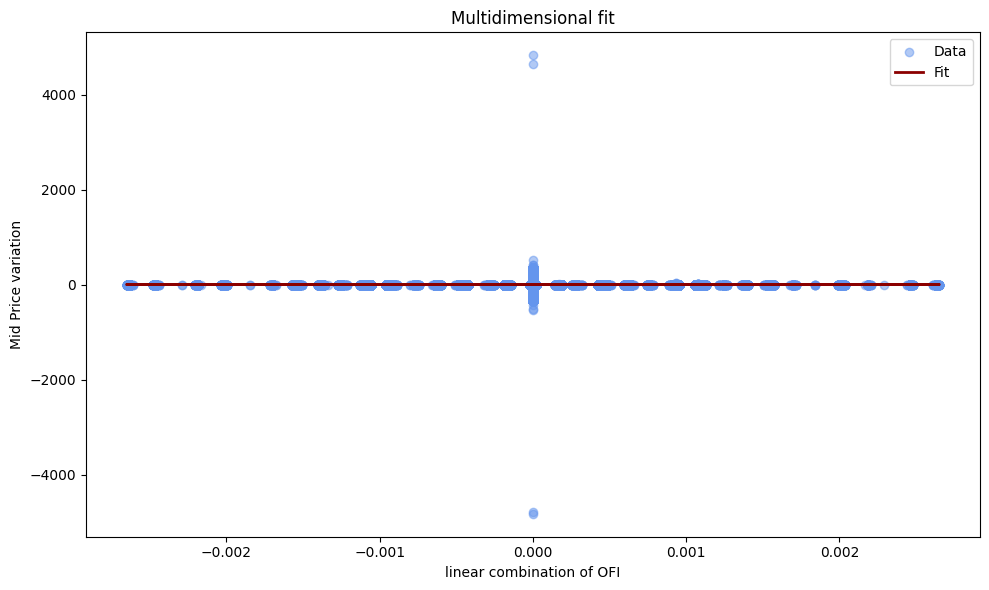

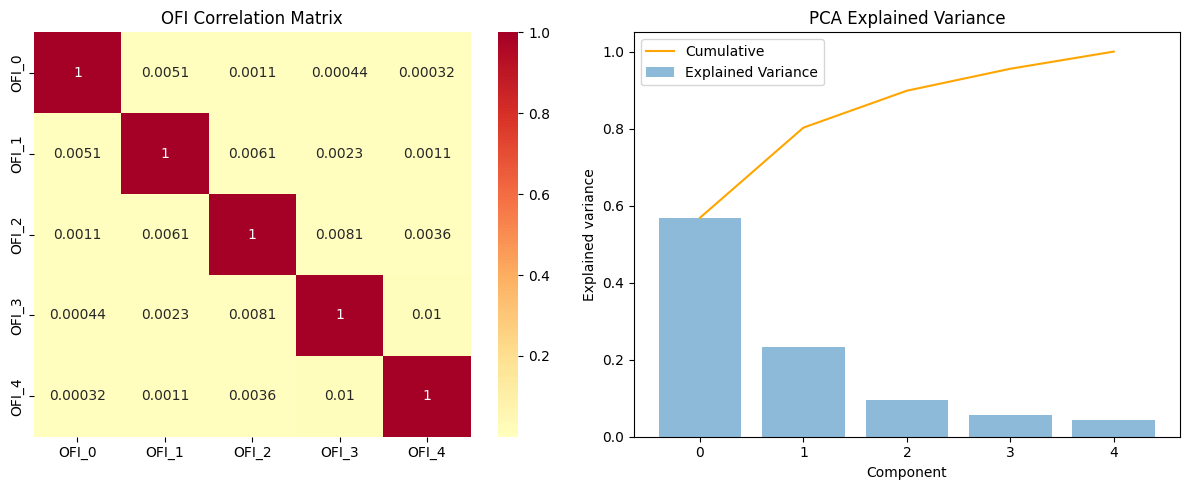


MULTIDIMENSIONAL LINEAR REGRESSION
α = 0.0000
β = [0.000000, 0.000000, 0.000000, 0.000000, 0.000000]
R² = 0.00


In [69]:
# 1. First calculate OFIs
def process_order_flow_imbalance(df, maxlevel=5, tick_size=1.0):
    """
    Computes OFI and mid-price evolution
    """
    # Ensure the dataframe is sorted by timestamp
    df = df.sort_values('ts_event').reset_index(drop=True)
    
    # Calculate Mid-Price
    df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
    
    # Initialize OFI columns
    for level in range(maxlevel):
        df[f'delta_W_{level}'] = np.zeros(len(df))
        df[f'delta_V_{level}'] = np.zeros(len(df))
        df[f'OFI_{level}'] = np.zeros(len(df))
    
    # Compute OFI for each level
    for level in range(maxlevel):
        bid_px = df[f'bid_px_{level:02d}']
        ask_px = df[f'ask_px_{level:02d}']
        bid_sz = df[f'bid_sz_{level:02d}']
        ask_sz = df[f'ask_sz_{level:02d}']
        
        # Calculate price differences
        bid_price_diff = np.diff(bid_px, prepend=bid_px.iloc[0])
        ask_price_diff = np.diff(ask_px, prepend=ask_px.iloc[0])
        
        # Calculate changes in bid and ask sizes
        delta_W = np.where(bid_price_diff > 0, bid_sz,
                          np.where(bid_price_diff == 0, bid_sz.diff().fillna(0),
                                 -bid_sz.shift(1).fillna(0)))
        
        delta_V = np.where(ask_price_diff < 0, ask_sz,
                          np.where(ask_price_diff == 0, ask_sz.diff().fillna(0),
                                 -ask_sz.shift(1).fillna(0)))
        
        # Store results
        df[f'delta_W_{level}'] = delta_W
        df[f'delta_V_{level}'] = delta_V
        df[f'OFI_{level}'] = delta_W - delta_V
    
    return df

# 2. Then prepare data for analysis
def prepare_ofi_data(df):
    """
    Prepare OFI values and mid-price delta
    """
    # Get OFI values
    OFI_values = df[[f'OFI_{i}' for i in range(5)]]
    
    # Calculate mid-price delta
    mid_price_delta = df['mid_price'].diff()
    
    return OFI_values, mid_price_delta

# 3. Run the complete analysis
# First, calculate OFIs
df = process_order_flow_imbalance(df)

# Then prepare data for analysis
OFI_values, mid_price_delta = prepare_ofi_data(df)

# Drop any NaN values
mask = ~(OFI_values.isna().any(axis=1) | mid_price_delta.isna())
OFI_values = OFI_values[mask]
mid_price_delta = mid_price_delta[mask]

# Now run the analysis
alpha, betas, r2, pca = analyze_multilevel_ofi(OFI_values, mid_price_delta)